# 必要なライブラリのインストール

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 8.9 MB/s eta 0:00:00


# Googleドライブのマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/submit/'

/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/submit


参考
- Lecture05のやり方をベースに改変

## ライブラリのインポート

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import random
import pandas as pd
from PIL import Image


rng = np.random.RandomState(1234)
random_state = 42


## データセットの読み込みと可視化

In [5]:
from torch.utils.data import Dataset
import os


# PyTorchのDatasetクラスをサブクラス化して独自のクラスを作成
# trainかtestかで挙動を変えられるようにする

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.labels_dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform


    def __len__(self):
        return len(self.labels_dataframe)

    def __getitem__(self, idx):
        # self.labels_dataframeに存在する画像ファイルのみ取り込む
        img_path = os.path.join(self.img_dir, self.labels_dataframe.iloc[idx, 0].split('-')[0], self.labels_dataframe.iloc[idx, 0].split('-')[1] + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label = self.labels_dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label



In [6]:
# 画像データの前処理
transform = transforms.Compose([
    transforms.ToTensor(),
])


# データ
path_to_csv_file = './data/labels/labels_sensitivity_evaluation.csv'
path_to_images = './data/images/'

# データフレーム全体を読み込む
labels_dataframe = pd.read_csv(path_to_csv_file)

# 嗜好が3のものは除外する
labels_dataframe = labels_dataframe[labels_dataframe.iloc[:, 1]!=3]

# 2列目の値が1,2のものを0に変換
labels_dataframe.iloc[:, 1].replace([1, 2], 0, inplace=True)

# 2列目の値が4,5のものを1に変換
labels_dataframe.iloc[:, 1].replace([4, 5], 1, inplace=True)

# trainとtest用にデータを8:2に分割
trainval_df, test_df = train_test_split(labels_dataframe, test_size=0.2, random_state=42, stratify=labels_dataframe['label'])

# 分割したデータフレームをそれぞれのインスタンスに渡す。
trainval_data = CustomImageDataset(trainval_df, img_dir=path_to_images, transform=None)
test_data = CustomImageDataset(test_df, img_dir=path_to_images, transform=None)




## 畳み込みニューラルネットワーク(CNN)の実装

In [7]:
def fix_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


fix_seed(seed=42)


class gcn():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ




参考サイト
- Pystyle
  - Pytorch – torchvision で使える Transform まとめ
  - https://pystyle.info/pytorch-list-of-transforms/#outline__6_3

In [8]:
val_size = 100
train_data, val_data = torch.utils.data.random_split(trainval_data, [len(trainval_data)-val_size, val_size])  # 訓練データと検証データに分割


# 前処理を定義
# データ拡張は汎化性能を高くするために訓練時には適用するが、性能評価の際には利用しない

GCN = gcn()

transform_train = transforms.Compose([
                                      # まず画像サイズを揃える
                                      transforms.Resize(512),           # 短辺がこの値になるようにリサイズ
                                      transforms.CenterCrop(512),      # 1辺がこの値の正方形になるように中心で切り抜き。だいたい猫は写真の中央あたりにうつっているので問題ないと考える

                                      # Data Augmentation（テンソル変換前） 精度がむしろ下がる
                                      # transforms.RandomHorizontalFlip(p=1.0),  # horizontally flipping
                                      # transforms.RandomRotation(degrees=(-5, 5)),  # random rotation
                                      # transforms.RandomCrop(32, padding=(4, 4, 4, 4), padding_mode='constant'),  # random cropping
                                      # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),   # Brightness, Contrast, Saturation


                                      # テンソル変換
                                      transforms.ToTensor(),


                                      # Data Augmentation（テンソル変換後） 精度がむしろ下がる
                                      # transforms.RandomErasing(p=0.8, scale=(0.02, 0.33), ratio=(0.3, 3.3)), # random erasing


                                      # Preprocessing
                                      GCN,
                                      # zca  # メモリ不足で実行できない
                                      ])

transform = transforms.Compose([
                                #まず画像サイズを揃える
                                transforms.Resize(512),           # 短辺がこの値になるようにリサイズ
                                transforms.CenterCrop(512),      # 1辺がこの値の正方形になるように中心で切り抜き。だいたい猫は写真の中央あたりにうつっているので問題ないと考える

                                # テンソル変換
                                transforms.ToTensor(),

                                # Preprocessing
                                GCN,
                                ])

# データセットに前処理を設定
trainval_data.transform = transform_train
test_data.transform = transform

batch_size = 64

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [9]:

rng = np.random.RandomState(1234)
random_state = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
# 画像サイズ512×512用、フィルタは32個

conv_net = nn.Sequential(

    nn.Conv2d(3, 32, 2),              # 512x512x3 -> 511x511x32
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 511x511x32 -> 255x255x32

    nn.Conv2d(32, 64, 2),             # 255x255x32 -> 254x254x64
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 254x254x64 -> 127x127x64

    nn.Conv2d(64, 128, 2),            # 127x127x64 -> 126x126x128
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 126x126x128 -> 63x63x128

    nn.Conv2d(128, 256, 2),           # 63x63x128 -> 62x62x256
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 62x62x256 -> 31x31x256

    nn.Conv2d(256, 512, 2),           # 31x31x256 -> 30x30x512
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 30x30x512 -> 15x15x512

    nn.Conv2d(512, 1024, 2),          # 15x15x512 -> 14x14x1024
    nn.BatchNorm2d(1024),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 14x14x1024 -> 7x7x1024

    nn.Conv2d(1024, 2048, 2),         # 7x7x1024 -> 6x6x2048
    nn.BatchNorm2d(2048),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 6x6x2048 -> 3x3x2048

    nn.Conv2d(2048, 4096, 2),         # 3x3x2048 -> 2x2x4096
    nn.BatchNorm2d(4096),
    nn.ReLU(),
    nn.AvgPool2d(2),                  # 2x2x4096 -> 1x1x4096

    nn.Flatten(),

    nn.Linear(1*1*4096, 8192),        # 直近のAvgPool2dに従って入力次元を調整

    nn.ReLU(),

    nn.Dropout(0.2),

    nn.Linear(8192, 2)                # クラス数に応じて出力次元を調整

)


In [11]:
# cosine scheduler
class CosineScheduler:
    def __init__(self, epochs, lr, warmup_length=5):
        """
        Arguments
        ---------
        epochs : int
            学習のエポック数．
        lr : float
            学習率．
        warmup_length : int
            warmupを適用するエポック数．
        """
        self.epochs = epochs
        self.lr = lr
        self.warmup = warmup_length

    def __call__(self, epoch):
        """
        Arguments
        ---------
        epoch : int
            現在のエポック数．
        """
        progress = (epoch - self.warmup) / (self.epochs - self.warmup)
        progress = np.clip(progress, 0.0, 1.0)
        lr = self.lr * 0.5 * (1. + np.cos(np.pi * progress))

        if self.warmup:
            lr = lr * min(1., (epoch+1) / self.warmup)

        return lr

def set_lr(lr, optimizer):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [12]:
def init_weights(m):  # Heの初期化
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)


conv_net.apply(init_weights)


n_epochs = 25
warmup_length = round(n_epochs * 0.1, 0)
lr = 0.001

device = 'cuda'

conv_net.to(device)
optimizer = optim.Adam(conv_net.parameters(), lr=lr)

# 学習率の更新定義
scheduler = CosineScheduler(epochs=n_epochs, lr=lr, warmup_length=warmup_length)

loss_function = nn.CrossEntropyLoss()  #　nn.ClossEntropyLossは，出力のsoftmax変換と，正解ラベルのone-hot vector化の機能を持っている





In [13]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

accuracy_train = MulticlassAccuracy(2, average='weighted').to(device)
precision_train = MulticlassPrecision(2, average='weighted').to(device)
recall_train = MulticlassRecall(2, average='weighted').to(device)
f1_train = MulticlassF1Score(2, average='weighted').to(device)

accuracy_valid = MulticlassAccuracy(2, average='weighted').to(device)
precision_valid = MulticlassPrecision(2, average='weighted').to(device)
recall_valid = MulticlassRecall(2, average='weighted').to(device)
f1_valid = MulticlassF1Score(2, average='weighted').to(device)


for epoch in range(n_epochs):

    # スケジューラで学習率を更新する
    new_lr = scheduler(epoch)
    set_lr(new_lr, optimizer)

    losses_train = []
    losses_valid = []

    conv_net.train()
    n_train = 0
    for x, t in dataloader_train:

        n_train += t.size()[0]

        conv_net.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)  # 自動でone-hot化してくれるので、自分で実装する必要がない

        y = conv_net.forward(x)  # 順伝播

        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        loss.backward()  # 誤差の逆伝播

        optimizer.step()  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする


        accuracy_train.update(pred, t)
        precision_train.update(pred, t)
        recall_train.update(pred, t)
        f1_train.update(pred, t)

        losses_train.append(loss.tolist())


    conv_net.eval()
    n_val = 0
    for x, t in dataloader_valid:

        # validはtrainと比較して、勾配の初期化、誤差の逆伝播、パラメータの更新が不要なためなくしている

        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = conv_net.forward(x)  # 順伝播

        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        accuracy_valid.update(pred, t)
        precision_valid.update(pred, t)
        recall_valid.update(pred, t)
        f1_valid.update(pred, t)
        losses_valid.append(loss.tolist())



    accuracy_train_epoch = accuracy_train.compute()
    precision_train_epoch = precision_train.compute()
    recall_train_epoch = recall_train.compute()
    f1_train_epoch = f1_train.compute()

    accuracy_valid_epoch = accuracy_valid.compute()
    precision_valid_epoch = precision_valid.compute()
    recall_valid_epoch = recall_valid.compute()
    f1_valid_epoch = f1_valid.compute()

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}]'.format(
        epoch,
        np.mean(losses_train),
        accuracy_train_epoch,
        precision_train_epoch,
        recall_train_epoch,
        f1_train_epoch,
        np.mean(losses_valid),
        accuracy_valid_epoch,
        precision_valid_epoch,
        recall_valid_epoch,
        f1_valid_epoch
    ))

    # 次のepochのためにリセット
    accuracy_train.reset()
    precision_train.reset()
    recall_train.reset()
    f1_train.reset()

    accuracy_valid.reset()
    precision_valid.reset()
    recall_valid.reset()
    f1_valid.reset()




EPOCH: 0, Train [Loss: 12.724, Accuracy: 0.500, Precision: 0.503, Recall: 0.500, F1: 0.500], Valid [Loss: 5.850, Accuracy: 0.490, Precision: 0.755, Recall: 0.490, F1: 0.343]
EPOCH: 1, Train [Loss: 10.710, Accuracy: 0.583, Precision: 0.583, Recall: 0.583, F1: 0.583], Valid [Loss: 50.027, Accuracy: 0.470, Precision: 0.221, Recall: 0.470, F1: 0.301]
EPOCH: 2, Train [Loss: 9.902, Accuracy: 0.528, Precision: 0.279, Recall: 0.528, F1: 0.365], Valid [Loss: 17.455, Accuracy: 0.480, Precision: 0.496, Recall: 0.480, F1: 0.440]
EPOCH: 3, Train [Loss: 2.137, Accuracy: 0.620, Precision: 0.714, Recall: 0.620, F1: 0.559], Valid [Loss: 9.978, Accuracy: 0.420, Precision: 0.423, Recall: 0.420, F1: 0.411]
EPOCH: 4, Train [Loss: 1.162, Accuracy: 0.583, Precision: 0.741, Recall: 0.583, F1: 0.519], Valid [Loss: 1.959, Accuracy: 0.450, Precision: 0.455, Recall: 0.450, F1: 0.423]
EPOCH: 5, Train [Loss: 1.050, Accuracy: 0.537, Precision: 0.708, Recall: 0.537, F1: 0.443], Valid [Loss: 1.555, Accuracy: 0.500, Pr

# testデータで性能検証

In [14]:
conv_net.eval()

t_true = []
t_pred = []
for data, labels in dataloader_test:

    data = data.to(device)

    # 順伝播
    y = conv_net.forward(data)

    # 予測値を格納
    t_pred.extend(y.detach().cpu().numpy())

    # labelを格納
    t_true.extend(labels.numpy())


# numpy arraysに変換
t_pred = np.array(t_pred)
t_true = np.array(t_true)

# 予測の出力がロジットなので、確率に変換するためにはシグモイド関数を適用
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

t_pred_sigmoid = sigmoid(t_pred[:, 1])

### ROCカーブ

ROC AUC: 0.48668639053254437


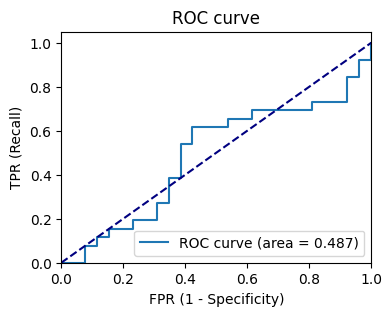

In [15]:
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(t_true, t_pred_sigmoid)
print(f"ROC AUC: {roc_auc}")

# ROCカーブの値を計算
fpr, tpr, thresholds = roc_curve(t_true, t_pred_sigmoid)

# ROCカーブをプロット
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR (1 - Specificity)')
plt.ylabel('TPR (Recall)')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

### 閾値を変更した場合の各指標の値

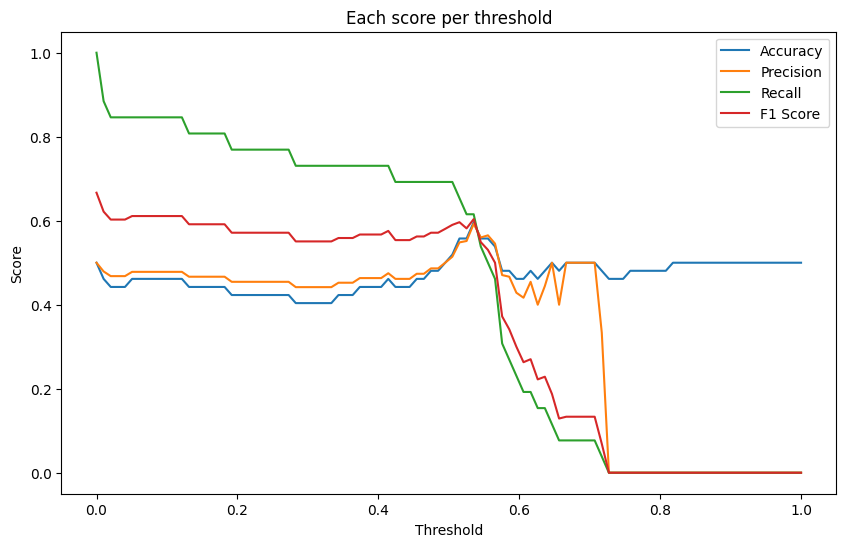

In [16]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# 様々な閾値で値を計算
thresholds = np.linspace(0, 1, 100)
accuracies = []
precisions = []
recalls = []
f1_scores = []
for threshold in thresholds:
    t_pred_class = (t_pred_sigmoid > threshold).astype(int)
    accuracies.append(accuracy_score(t_true, t_pred_class))
    precisions.append(precision_score(t_true, t_pred_class))
    recalls.append(recall_score(t_true, t_pred_class))
    f1_scores.append(f1_score(t_true, t_pred_class))

# 各指標をプロット
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Each score per threshold')
plt.legend()
plt.show()



### 混同行列

In [17]:
# 指定した閾値で混同行列を計算
threshold = 0.55
t_pred_class = (t_pred_sigmoid > threshold).astype(int)
cm = confusion_matrix(t_true, t_pred_class)
print(f"混同行列の閾値 {threshold}:\n{cm}")

混同行列の閾値 0.55:
[[16 10]
 [13 13]]
